In [ ]:
"""
Used for creating price data, analysing that data and creating price periods.
"""

In [2]:
# imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import lib.base_strategy as bs
import lib.init_data_helper as idh
from fractions import Fraction as frac
from tests.test_all_tests import get_test_data_path

from lib.get_binance_data import get_binance_data
from lib.get_coinbase_data import get_coinbase_data

In [2]:
# Read in csv's

# Collect these files from Kaggle here:
# https://www.kaggle.com/yamqwe/cryptocurrency-extra-data-ethereum
list_of_csv = [
    # TODO: figure out problems with 2017 data
    # 'full_data__6__2017.csv', # don't use 2017 data, its not great
    'full_data__6__2018.csv',
    'full_data__6__2019.csv',
    'full_data__6__2020.csv',
    'full_data__6__2021.csv'
]
sorted_list_of_csv = [
    # 'sorted_full_data_2017.csv',
    'sorted_full_data_2018.csv',
    'sorted_full_data_2019.csv',
    'sorted_full_data_2020.csv',
    'sorted_full_data_2021.csv'
]

In [ ]:
# Get CoinBase Data - Takes around ~330 min to collect all historic data

# Make sure we actually want to get the data
get_data = True
if get_data:
    # Split data collection into two parts so that it doesn't error out
    part_1 = get_coinbase_data(start_date='2018-01-01-00-00', end_date='2020-01-1-00-00')
    # Don't pass end_date to use current time as end
    part_2 = get_coinbase_data(start_date='2020-01-01-00-00')
    print('Querying complete.')

    # Combine parts
    coinbase_data = idh.combine_datasets(part_1, part_2)
    # drop index so we don't get two index columns
    coinbase_data = coinbase_data.drop(columns=['index'])
    print('Combining data complete.')
    # Give index a name
    coinbase_data.index.names = ['index']

    # Save data
    print(f'\nHistorical values found: {len(coinbase_data.index)}')
    coinbase_data.to_csv(bs.full_path('CoinBase_ETH_all_price_data'))
    print(f'\nSubset of final data:\n{coinbase_data.tail(5)}')
    print('Done!')


In [11]:
# CoinBase price data analysis
# Read the dataframe in case we are just running this cell on its own
coinbase_df = pd.read_csv(bs.full_path('CoinBase_ETH_all_price_data'))
# Check if we have any timestamp gaps in our data.
idh.check_missing_timestamp(coinbase_df)
print('\n') # Spacing

# Test price jumps, up or down by more than a specific amount.
# This can help show where our price data may be bad or incomplete.
idh.check_price_jump(coinbase_df)

Number of missing timestamps: 14751
Missing timestamps: 
[1516145640 1516147800 1516308000 ... 1637918340 1637921460 1642849500]


Looking for a difference of 10.0% or more.
Number of jumps: 0
Big Jumps: 
Empty DataFrame
Columns: [index, timestamp, fraction_price, decimal_price, next_decimal_price, multiplier]
Index: []


In [ ]:
# Get Binance Data - Takes around ~80 min to collect all historic data

# Make sure we actually want to get the data
get_data = True
if get_data:
    # USDT has more historical price data than USDC but either can be used
    TRADING_PAIR = 'ETHUSDT'
    # TRADING_PAIR = 'ETHUSDC'
    if TRADING_PAIR == 'ETHUSDT':
        ## For ETH USDT
        # Earliest timestamp found: 1502942400.0
        # Human readable format: Wed Aug 16 21:00:00 2017
        # However, early Binance ETH USDT data is not very good so only use 2018+ (aka 1514764800+)
        # Multiply by 1000 to make what we would get from the query
        start_date = 1514764800*1000
        # For ETH USDC (not quite as much data as USDT)
        # Earliest timestamp found: 1544844060.0
        # Human readable format: Fri Dec 14 19:21:00 2018
    else:
        start_date = ''

    df_klines = get_binance_data(TRADING_PAIR, start_date)

    # save data as a file
    save_file_name = 'Binance_ETH_all_price_data.csv'
    df_klines.to_csv(bs.full_path(save_file_name))

In [9]:
# Binance price data analysis
# Read the dataframe in case we are just running this cell on its own
binance_df = pd.read_csv(bs.full_path('Binance_ETH_all_price_data.csv'))
# Check if we have any timestamp gaps in our data.
idh.check_missing_timestamp(binance_df)
print('\n') # Spacing

# Test price jumps, up or down by more than a specific amount.
# This can help show where our price data may be bad or incomplete.
idh.check_price_jump(binance_df)

Number of missing timestamps: 30
Missing timestamps: 
[1515034860 1518049740 1518242414 1518321660 1529978400 1530104400
 1530663780 1539928800 1542160800 1552356000 1557889200 1559942040
 1565834400 1573610400 1573623000 1574647200 1581213600 1582112160
 1583313720 1587780000 1593309600 1606716000 1608559740 1608861600
 1613014860 1614996000 1618884000 1619323260 1628820000 1632898800]


Looking for a difference of 10.0% or more.
Number of jumps: 0
Big Jumps: 
Empty DataFrame
Columns: [index, timestamp, fraction_price, decimal_price, next_decimal_price, multiplier]
Index: []


In [ ]:
# Test if csv are sorted
for csv in list_of_csv:
    data = pd.read_csv(bs.full_path(csv))
    sorted_data = data.sort_values(by=['timestamp'])
    print(f'{csv} is sorted?: {data.equals(sorted_data)}')
    # The above resulted in 
    # full_data__6__2018.csv is sorted?: True
    # full_data__6__2019.csv is sorted?: False
    # full_data__6__2020.csv is sorted?: False
    # full_data__6__2021.csv is sorted?: False
    # So we have to sort the data (only do this once)
    
    # Test for nulls
    null_counts = sorted_data[['timestamp', 'Open', 'Close', 'High', 'Low']].isnull().sum()
    null_counts[null_counts > 0].sort_values(ascending=False)
    print('Null values found:')
    print(null_counts)
    # No nulls!

    # Create 'price' column from avg of Open and Close
    # First make the row and round to 4 decimals
    # Divide by 4 after we make the fraction_price
    sorted_data['decimal_price'] = round(sorted_data['Open'] + sorted_data['Close'] + sorted_data['High'] + sorted_data['Low'],
         4)
    # Then fractionalize the number to minimize floating point rounding errors
    sorted_data['fraction_price'] = sorted_data['decimal_price'].apply(lambda x: frac(x)/4)
    # Average out decimal price
    sorted_data['decimal_price'] = sorted_data['decimal_price']/4
    # Give the index a name for the csv
    sorted_data.index.names = ['index']
    # drop all columns we don't want
    sorted_data = sorted_data.filter(['index', 'timestamp', 'fraction_price', 'decimal_price'])
    # Only run this once
    # NOTE: Uncomment this when running for the first time
    # sorted_data.to_csv(bs.full_path('sorted_full_data_'+ csv[-8:]))

# Spacing
print('\nSorted check:')
# Show that sorted data is sorted
for csv in sorted_list_of_csv:
    data = pd.read_csv(bs.full_path(csv))
    sorted_data = data.sort_values(by=['timestamp'])
    print(f'{csv} is sorted?: {data.equals(sorted_data)}')



In [ ]:
# Combine ALL data into one big file

# initialize list of all of the files we want to look at
overall_list = [
    'Binance_ETH_all_price_data.csv',
    'CoinBase_ETH_all_price_data.csv'
]
# add the Kaggle data to our list
overall_list = overall_list + sorted_list_of_csv

# initialize empty dataframe to hold all the values
combined_df = pd.DataFrame(columns=['index', 'timestamp', 'fraction_price', 'decimal_price'])

# combine all the data into one dataset
for csv in overall_list:
    print(f'Adding {csv}')
    new_data = pd.read_csv(bs.full_path(csv))
    combined_df = idh.combine_datasets(combined_df, new_data)

# Drop the fake index
combined_df = combined_df.drop(columns=['index'])
# Name the real index for the csv
combined_df.index.names = ['index']

# save result to a file
combined_df.to_csv(bs.full_path('Combined_ETH_all_price_data.csv'))
print('Results Saved!\n')

In [10]:
# Price data analysis
# Validate our final combined dataframe
combined_df = pd.read_csv(bs.full_path('Combined_ETH_all_price_data.csv'))

# Check if we have any timestamp gaps in our data.
# This could affect strategy performance if enough are present.
# Adding more data sources will reduce breaks in timestamp data and will make our average price more accurate due to 
    # being less sensitive to the price on one exchange.
idh.check_missing_timestamp(combined_df)
print('\n') # Spacing

# Test price jumps, up or down by more than a specific amount.
# This can help show where our price data may be bad or incomplete.
idh.check_price_jump(combined_df)

Number of missing timestamps: 1
Missing timestamps: 
[1518242414]


Looking for a difference of 10.0% or more.
Number of jumps: 2
Big Jumps: 
    index   timestamp                     fraction_price  decimal_price  next_decimal_price  multiplier
0  505646  1545031500  24004150829512655/281474976710656        85.2799            101.1726        1.19
1  505648  1545031620      906617046138513/8796093022208       103.0704             85.3522        0.83


In [5]:
# Get fear and greed indicator data


fng_url = 'https://api.alternative.me/fng/?limit=0'
fng = requests.get(fng_url)
# print(fng.json())
fng_df = pd.DataFrame.from_dict(fng.json()['data'])
# data formatting
fng_df['value'] = fng_df['value'].astype(int)
fng_df['timestamp'] = fng_df['timestamp'].astype(int)
fng_df['date'] = pd.to_datetime(fng_df['timestamp'], unit='s').dt.strftime("%m-%d-%Y")
fng_df = fng_df.sort_values('timestamp')
fng_df = fng_df.reset_index(drop=True)
fng_df.index.names = ['index']
# save data to a file
fng_df.to_csv(bs.full_path('fear_and_greed.csv'))

print(fng_df)

       value value_classification   timestamp time_until_update        date
index                                                                      
0         30                 Fear  1517443200               NaN  02-01-2018
1         15         Extreme Fear  1517529600               NaN  02-02-2018
2         40                 Fear  1517616000               NaN  02-03-2018
3         24         Extreme Fear  1517702400               NaN  02-04-2018
4         11         Extreme Fear  1517788800               NaN  02-05-2018
...      ...                  ...         ...               ...         ...
1508      31                 Fear  1647993600               NaN  03-23-2022
1509      40                 Fear  1648080000               NaN  03-24-2022
1510      47              Neutral  1648166400               NaN  03-25-2022
1511      51              Neutral  1648252800               NaN  03-26-2022
1512      49              Neutral  1648339200             75548  03-27-2022

[1513 rows 

In [ ]:
# idh.create_price_period('1/1/2018','1/5/2018', 'test')
# idh.create_price_period('1/1/2018','2/1/2018', 'test_month')

# --- Specific price_periods --- 
# Yearly
idh.create_price_period('1/1/2018','1/1/2019', '2018_price_data')
idh.create_price_period('1/1/2019','1/1/2020', '2019_price_data')
idh.create_price_period('1/1/2020','1/1/2021', '2020_price_data')
idh.create_price_period('1/1/2021','1/1/2022', '2021_price_data') 
# Past 4 Years - 2018 through 2021
idh.create_price_period('1/1/2018', '1/1/2022', '2018-2021')
# Past 3 Years - 2019 through 2021
idh.create_price_period('1/1/2019', '1/1/2022', '2019-2021')
# Past 2 Years - 2020 through 2021
idh.create_price_period('1/1/2020', '1/1/2022', '2020-2021')
# Past 1 Year - all of 2021 # Low to high to low to high
idh.create_price_period('1/1/2021', '1/1/2022', '2021')

# High to low 
# - 1515870180 (max of 2018) to end of 2018
idh.create_price_period(1515870180, 1546300740, 'High-Low-1')
# - 1620125000 (before 2021 crash) to 1627000000 (2021 crash low)
idh.create_price_period(1620125000, 1627000000, 'High-Low-2')

# Low to high 
# - start of 2020 to 1620125000 (before 2021 crash)
idh.create_price_period('1/1/2020', 1620125000, 'Low-High-1')
# - 1627000000 (2021 crash low) to end of 2021
idh.create_price_period(1627000000, '1/1/2022', 'Low-High-2')

# Low to high to low
# - all of 2019
idh.create_price_period('1/1/2019', 1577836740, 'Low-High-Low-1')
# - 2021 start to 1627000000 (2021 crash low)
idh.create_price_period('1/1/2021', 1627000000, 'Low-High-Low-2')

# High to low to high
# - 1515870180 (2018) to 1620125000 (before 2021 crash)
idh.create_price_period(1515870180, 1620125000, 'High-Low-High-1')
# - 1620125000 (before 2021 crash) to end of 2021
idh.create_price_period(1620125000, '1/1/2022', 'High-Low-High-2')

Start datetime: 2018-01-01 08:01:00
End datetime:   2018-01-05 07:59:00


<AxesSubplot:xlabel='timestamp'>

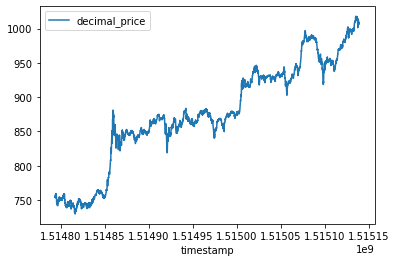

In [6]:
# Recalibrate time variable in a new row to start at 0
# start_time = data['Time'].values[0]
# data['Cal Time'] = data['Time'].apply(lambda x: x - start_time)

# Examples
# Plot data returned
# By default x=index
# data.plot(y='Price', kind='line')
# data.plot(x='Cal Time', y=['Price', 'Plus .3%', 'Minus .3%'], kind='line')
# data.plot(x='Cal Time', y=['Price', 'Plus .3%', 'Minus .3%'], kind='line', xlim=(35000,45000))
# data.plot(x='Cal Time', y=['Price', 'Plus .3%', 'Minus .3%'], kind='line', ylim=(data['Price'].mean()*(1-.005),data['Price'].mean()*(1+.005)))

# testing
data = pd.read_csv(get_test_data_path('test.csv'), index_col='index')
# print(type(data['fraction_price'].values[0]))
# print(dir(data['price'].values[0]))
start_datetime = pd.to_datetime(data['timestamp'].iloc[0], unit='s')
end_datetime = pd.to_datetime(data['timestamp'].iloc[-1], unit='s')
print(f'Start datetime: {start_datetime}')
print(f'End datetime:   {end_datetime}')
data.plot(x='timestamp', y='decimal_price', kind='line')

Start datetime: 2018-01-01 00:01:00
End datetime:   2018-12-31 23:59:00
Start datetime: 2019-01-01 00:01:00
End datetime:   2019-12-31 23:59:00
Start datetime: 2020-01-01 00:01:00
End datetime:   2020-12-31 23:59:00
Start datetime: 2021-01-01 00:01:00
End datetime:   2021-11-26 23:43:00


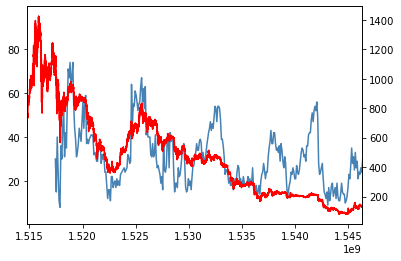

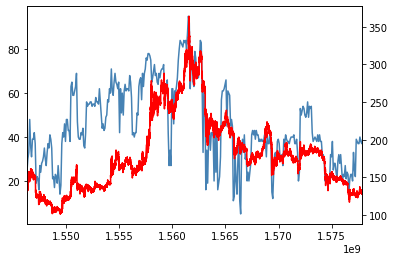

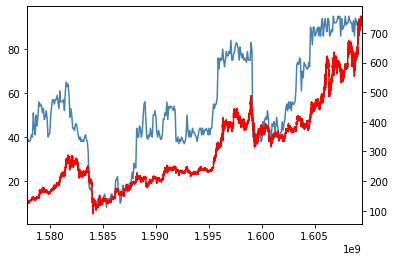

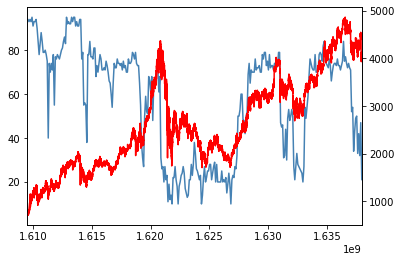

In [12]:
# Yearly Price Plots
# get fear and greed data
fng_data = pd.read_csv(bs.full_path('fear_and_greed.csv'), index_col='index')
#define colors to use
col1 = 'steelblue'
col2 = 'red'

for csv in sorted_list_of_csv:
    data = pd.read_csv(bs.full_path(csv), index_col='index')
    start_datetime = pd.to_datetime(data['timestamp'].iloc[0], unit='s')
    end_datetime = pd.to_datetime(data['timestamp'].iloc[-1], unit='s')
    print(f'Start datetime: {start_datetime}')
    print(f'End datetime:   {end_datetime}')
    # data.plot(x='timestamp', y='decimal_price', title=csv, kind='line')
    
    #define subplots
    fig,ax = plt.subplots()
    ax.plot(fng_df.timestamp, fng_df.value, color=col1)
    ax.set_xlim(data['timestamp'].iloc[0], data['timestamp'].iloc[-1])
    ax2 = ax.twinx()
    #add second line to plot
    ax2.plot(data.timestamp, data.decimal_price, color=col2)
    # ax2.set_yscale('log')

Combined_ETH_all_price_data.csv


C:\Users\Victor\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Start datetime: 2018-01-01 00:00:00
End datetime:   2022-02-16 09:40:00


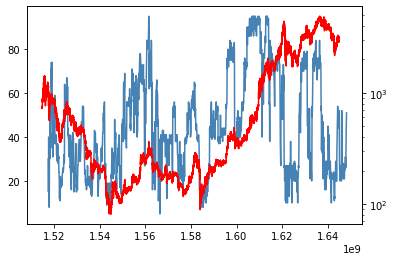

In [5]:
csv = 'Combined_ETH_all_price_data.csv'
print(csv)
data = pd.read_csv(bs.full_path(csv), index_col='index')
start_datetime = pd.to_datetime(data['timestamp'].iloc[0], unit='s')
end_datetime = pd.to_datetime(data['timestamp'].iloc[-1], unit='s')
print(f'Start datetime: {start_datetime}')
print(f'End datetime:   {end_datetime}')

# print(data)
# print(fng_df)
# data.plot(x='timestamp', y='decimal_price', title=csv, kind='line')
# ax = fng_df['value'].plot(x='timestamp', secondary_y=True)


#define colors to use
col1 = 'steelblue'
col2 = 'red'
#define subplots
fig,ax = plt.subplots()
ax.plot(fng_df.timestamp, fng_df.value, color=col1)
# ax.set_yscale('log')
ax2 = ax.twinx()
#add second line to plot
ax2.plot(data.timestamp, data.decimal_price, color=col2)
ax2.set_yscale('log')